# Introduction



In [1]:
# Import local libraries
import joblib
import os
from tqdm import tqdm
import warnings

# Import 3rd party libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import shuffle

# Functions

In [2]:
def look_for_pattern_in_NaN_tenure(data):
    """
    Prints descriptive statistics and value counts for specific columns in the given DataFrame
    where the 'Tenure' column has missing values.

    Parameters:
    - data: DataFrame
        The input DataFrame containing the data.

    Returns:
    None
    """
    temp_df = data[data['Tenure'].isna()]
    exclude = ['Tenure', 'RowNumber', 'CustomerId', 'Surname']
    describe = ['CreditScore', 'Age', 'Balance','EstimatedSalary']
    val_cnts = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']
    for col in data.columns:
        if col in exclude:
            continue
        if col in describe:
            print(temp_df[col].describe())
        if col in val_cnts:
            print(temp_df[col].value_counts(dropna=False))
        print()


In [3]:
def get_f1_auc_roc_and_plot(model, random_state, features_train, target_train, features_valid, target_valid):
    """
    Calculate the F1 score, AUC-ROC score, and plot the ROC curve for a given model.

    Parameters:
    - model: The machine learning model to be used.
    - random_state: The random state for reproducibility.
    - features_train: The training features.
    - target_train: The training target.
    - features_valid: The validation features.
    - target_valid: The validation target.

    Returns:
    - f1: The F1 score.
    - auc_roc: The AUC-ROC score.
    """

    if model == LogisticRegression:
        model = model(random_state=random_state, solver='liblinear')
    else:
        model = model(random_state=random_state)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)

    f1 = f1_score(target_valid, predictions_valid)
    auc_roc = roc_auc_score(target_valid, predictions_valid)

    # Calculate the ROC curve
    fpr, tpr, threshold = roc_curve(target_valid, predictions_valid)

    # Plot the ROC curve
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr,)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {model.__class__.__name__}')
    plt.legend(['Decision Tree', 'Random Guess'])
    plt.show()

    print({model.__class__.__name__})
    print(f"F1 Score: {f1}")
    print(f"AUC-ROC Score: {auc_roc}")

    return f1, auc_roc


In [4]:
def load_results():
    pd.options.mode.chained_assignment = None  # default='warn' ignore the warning
    
    results = pd.read_csv('results/results.csv')
    
    # Add Model column
    results['model'] = None
    
    # Reorder the columns
    results = results[['f1_score', 'auc_roc', 'model', 'params', 'algorithm', 'method']]
    
    for i, row in results.iterrows():
        results['model'][i] = joblib.load(f'results/{i}.joblib')
        
    pd.options.mode.chained_assignment = 'warn'
    
    return results

In [5]:
def update_results(results, df, balance_method):
    # Add the balance method to the DataFrame
    df['method'] = balance_method
    
    # Concatenate the results and the new DataFrame
    results = pd.concat([results, df], ignore_index=True)
    
    return results

In [6]:
def validate_DecisionTreeClassifier(features_train, target_train, features_valid, target_valid, random_state,
                                class_weight=[None], max_depth=[None], splitter=['best'],
                                criterion=['gini'], min_samples_split=[2],
                                min_samples_leaf=[1], max_features=[None]):
    """
    Test different configurations of the DecisionTreeClassifier model and return the best score and parameters.
    
    Parameters:
    - features_train: The training features.
    - target_train: The training target.
    - features_valid: The validation features.
    - target_valid: The validation target.
    - random_state: The random state for reproducibility. Default is random_state.
    - class_weight: The class weight options. Default is [None, 'balanced']. Tests use of 'balanced' because the 'smart' plan is overrepresented in the data.
    - max_depth: The maximum depth of the tree. Default is a list from 1 to 20.
    - splitter: The strategy used to choose the split at each node. Default is ['best', 'random'].
    - criterion: The function to measure the quality of a split. Default is ['gini', 'entropy', 'log_loss].
    - min_samples_split: The minimum number of samples required to split an internal node. Default is a list from 2 to 18.
    - min_samples_leaf: The minimum number of samples required to be at a leaf node. Default is a list from 1 to 18.
    - max_features: The number of features to consider when looking for the best split. Default is [None, 'sqrt', 'log2'].
    - print_progress: Whether to print the progress of the model testing. Default is False.
    
    Returns:
    - best_score: The best score achieved by the model.
    - best_params: The parameters that resulted in the best score.
    - results_df: A DataFrame tracking the scores and parameters of each iteration.
    """
    
    results = pd.DataFrame(columns=['f1_score', 'auc_roc', 'model', 'params'])
    
    # Calculate total number of iterations
    total = len(class_weight) * len(max_depth) * len(splitter) * len(criterion) * len(min_samples_split) * len(min_samples_leaf) * len(max_features)

    # Wrap the loop in tqdm to show a progress bar
    with tqdm(total=total, desc='Testing DecisionTreeClassifier Parameters', unit='iterations') as pbar:
        for cw in class_weight:
            for md in max_depth:
                for s in splitter:
                    for c in criterion:
                        for mss in min_samples_split:
                            for msl in min_samples_leaf:
                                for mf in max_features:
                                    # Save params in a dict
                                    params = {'class_weight': cw, 'max_depth': md, 'splitter': s, 'criterion': c, 'min_samples_split': mss, 'min_samples_leaf': msl, 'max_features': mf}
                                    
                                    # Define and train the model
                                    model = DecisionTreeClassifier(random_state=random_state, class_weight=cw, max_depth=md, splitter=s, criterion=c, min_samples_split=mss, min_samples_leaf=msl, max_features=mf)
                                    model.fit(features_train, target_train)
                                    score = model.score(features_valid, target_valid)
                                    
                                    # Score the model
                                    predictions_valid = model.predict(features_valid)
                                    f1 = f1_score(target_valid, predictions_valid)
                                    auc_roc = roc_auc_score(target_valid, predictions_valid)
                                    
                                    # Save the results
                                    new_row = pd.DataFrame({'f1_score': [f1], 'auc_roc': [auc_roc], 'algorithm': ['DecisionTreeClassifier'], 'params': [params], 'model': [model]})
                                    results = pd.concat([results, new_row], ignore_index=True)
                                    
                                    # Sort results by descending f1_score
                                    results = results.sort_values(by='f1_score', ascending=False)
                                    
                                    # Keep only top 3 results
                                    results = results.head(1)
                                    
                                    # Update the progress bar
                                    pbar.update(1)
                                    
    return results   

In [7]:
def validate_RandomForrest(features_train, target_train, features_valid, target_valid,
                           class_weight=[None],
                           n_estimators=[50],
                           criterion=['gini'],
                           max_depth=[None],
                           min_samples_split=[2],
                           min_samples_leaf=[1],
                           max_features=['sqrt']):
    # Rest of the code...
    
    # Create a DataFrame to store the results
    results = pd.DataFrame(columns=['f1_score', 'auc_roc', 'model', 'params'])
    
    # Define the total for the progress bar
    total = len(class_weight) * len(n_estimators) * len(criterion) * len(max_depth) * len(min_samples_split) * len(min_samples_leaf) * len(max_features)
    # Initialize the progress bar
    with tqdm(total=total, desc='Testing RandomForestClassifier Parameters', unit='iterations') as pbar:
        for cw in class_weight:
            for ne in n_estimators:
                for c in criterion:
                    for md in max_depth:
                        for mss in min_samples_split:
                            for msl in min_samples_leaf:
                                for mf in max_features:
                                    # Save params in a dict
                                    params = {'class_weight': cw, 'n_estimators': ne, 'criterion': c, 'max_depth': md, 'min_samples_split': mss, 'min_samples_leaf': msl, 'max_features': mf,}
                                    # Define and train the model
                                    model = RandomForestClassifier(random_state=random_state, class_weight=cw, n_estimators=ne, criterion=c, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, max_features=mf)
                                    model.fit(features_train, target_train)
                                    # Score the model
                                    predictions_valid = model.predict(features_valid)
                                    f1 = f1_score(target_valid, predictions_valid)
                                    auc_roc = roc_auc_score(target_valid, predictions_valid)
                                    # Save the results
                                    new_row = pd.DataFrame({'f1_score': [f1], 'auc_roc': [auc_roc], 'algorithm': ['RandomForrestClassifier'], 'params': [params], 'model': [model]})
                                    results = pd.concat([results, new_row], ignore_index=True)
                                    # Sort results by descending f1_score
                                    results = results.sort_values(by='f1_score', ascending=False)
                                    # Keep only top 3 results
                                    results = results.head(1)
                                    # Update the progress bar
                                    pbar.update(1)
                                    
    return results

In [8]:
def validate_LogisticRegression(features_train, target_train, features_valid, target_valid, random_state,
                                class_weight = [None],
                                solvers = ['liblinear'],
                                duals = [False],
                                penalties = ['l2'],
                                max_iter = [100]):
    """
    Validates the Logistic Regression model with different parameter combinations.

    Parameters:
    - features_train: Training features data.
    - target_train: Training target data.
    - features_valid: Validation features data.
    - target_valid: Validation target data.
    - random_state: Random state for reproducibility.
    - solvers: List of solvers to test.
    - duals: List of dual values to test.
    - penalties: List of penalties to test.

    Returns:
    - best_score: Best score achieved by the model.
    - best_params: Best parameters combination that achieved the best score.
    """

    # Ignore ConvergenceWarning
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    # Ignore LineSearchWarning
    warnings.filterwarnings("ignore", message="^The line search algorithm did not converge")
    warnings.filterwarnings("ignore", message="^Line Search failed")
    
    # Create a DataFrame to store the results                                
    results = pd.DataFrame(columns=['f1_score', 'auc_roc', 'model', 'params'])

    # Initialize the progress bar
    with tqdm(total=len(class_weight) * len(solvers) * len(duals) * len(penalties), desc='Testing LogisticRegression Parameters', unit='iterations') as pbar:
        for weight in class_weight:
            for solver in solvers:
                for dual in duals:
                    for penalty in penalties:
                        for iter in max_iter:

                            # Save params in a dict
                            params = {'class_weight': weight, 'solver': solver, 'dual': dual, 'penalty': penalty, 'max_iter': iter}
                            
                            # Define, train, and score the model
                            model = LogisticRegression(random_state=random_state, class_weight=weight, solver=solver, dual=dual, penalty=penalty)
                            try: # try/except to handle invalid param combinations
                                model.fit(features_train, target_train)
                                # Score the model
                                predictions_valid = model.predict(features_valid)
                                f1 = f1_score(target_valid, predictions_valid)
                                auc_roc = roc_auc_score(target_valid, predictions_valid)
                                # Save the results
                                new_row = pd.DataFrame({'f1_score': [f1], 'auc_roc': [auc_roc], 'algorithm': ['LogisticRegression'], 'params': [params], 'model': [model]})
                                results = pd.concat([results, new_row], ignore_index=True)
                                # Sort results by descending f1_score
                                results = results.sort_values(by='f1_score', ascending=False)
                                # Keep only top 3 results
                                results = results.head(1)
                                
                                # Update the progress bar
                                pbar.update(1)
                            except:
                                pbar.update(1)
                                continue

        return results

In [9]:
def get_details(list_of_models, features_valid, target_valid):
    warnings.filterwarnings(action='ignore', category=UserWarning)

    model_index = 0

    for model in list_of_models:
        print(f"model_index: {model_index}")
    
        predictions_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions_valid)
        auc_roc = roc_auc_score(target_valid, predictions_valid)

        print(f"F1 Score: {f1}")
        print(f"AUC-ROC Score: {auc_roc}")

    # Plot the ROC curve
        fpr, tpr, thresholds = roc_curve(target_valid, predictions_valid)
    

        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr,)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC curve for {model.__class__.__name__} {model_index}')

        plt.show()
    
        model_index += 1
    
    # Return filterwarnings to default
    warnings.filterwarnings(action='default', category=UserWarning)


In [10]:
def save_results(results):
    
    if os.path.exists('results'):
        os.system('rm -rf results')
    
    os.mkdir('results')
    
    # Save each model from the results to the best_decision_tree directory
    for i, row in results.iterrows():
        joblib.dump(row['model'], f'results/{i}.joblib')
        
    # Drop the model column from the results
    results_temp = results.drop(columns='model')
    
    # Save the results to a csv file
    results_temp.to_csv('results/results.csv', index=False)

In [11]:
def upsample(features, target, repeat, random_state):
   
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=random_state)

    return features_upsampled, target_upsampled

In [12]:
def downsample(features, target, fraction, random_state):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=random_state)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=random_state)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=random_state)

    return features_downsampled, target_downsampled

In [13]:
def find_threshold(results, features_valid, target_valid):
    # Create a df
    temp_df = pd.DataFrame(columns=['f1_score', 'auc_roc', 'model', 'params', 'algorithm', 'method', 'threshold'])
    # For each row in the results
    for i, row in results.iterrows():
        # Define the model
        model = row['model']

        # Get the probabilities of the positive class
        probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
        
        # Test different thresholds
        for threshold in np.arange(0.0, 1.0, .02):
            # Convert probabilities to binary predictions
            predictions_valid = probabilities_one_valid > threshold
            # Calculate the f1 score
            f1 = f1_score(target_valid, predictions_valid)
            # Calculate the auc_roc score
            auc_roc = roc_auc_score(target_valid, predictions_valid)
            
            # Add the results to the temp_df
            temp_df = pd.concat([temp_df, pd.DataFrame({'f1_score': [f1], 'auc_roc': [auc_roc], 'model': [model], 'params': [row['params']], 'algorithm': [row['algorithm']], 'method': [row['method']], 'threshold': [threshold]})], ignore_index=True)
            
            # Sort the temp_df by descending f1_score, auc_roc
            temp_df = temp_df.sort_values(by=['f1_score', 'auc_roc'], ascending=False, ignore_index=True)
            
            # Keep only the top 3 results
            temp_df = temp_df.head(3)
            
    return temp_df

# Data Inspection and Cleaning

In [14]:
# Load the data
try: # If running locally
    data = pd.read_csv("Churn.csv")
except: # If running in the TripTen Environment
    data = pd.read_csv("/datasets/Churn.csv")

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [16]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [17]:
# Drop the RowNumber, and CustomerId columns since we will not want to use them as features in our model
data = data.drop(['RowNumber', 'CustomerId'], axis=1)

In [18]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [19]:
# Check for duplicates
data.duplicated().sum()

0

In [20]:
# Examine Tenure column
data['Tenure'].value_counts(dropna=False)

Tenure
1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
NaN     909
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: count, dtype: int64

We have 909 missing values in the Tenure column. Let's take a closer look to see if we might be able to find any pattern with these missing values.

In [21]:
look_for_pattern_in_NaN_tenure(data)

count    909.000000
mean     648.451045
std       99.079381
min      359.000000
25%      580.000000
50%      647.000000
75%      718.000000
max      850.000000
Name: CreditScore, dtype: float64

Geography
France     464
Spain      229
Germany    216
Name: count, dtype: int64

Gender
Male      483
Female    426
Name: count, dtype: int64

count    909.000000
mean      38.647965
std        9.785438
min       18.000000
25%       32.000000
50%       37.000000
75%       43.000000
max       92.000000
Name: Age, dtype: float64

count       909.000000
mean      76117.341474
std       63105.690715
min           0.000000
25%           0.000000
50%       96674.550000
75%      128554.980000
max      206663.750000
Name: Balance, dtype: float64

NumOfProducts
1    467
2    406
3     32
4      4
Name: count, dtype: int64

HasCrCard
1    646
0    263
Name: count, dtype: int64

IsActiveMember
1    464
0    445
Name: count, dtype: int64

count       909.000000
mean      99180.389373
std       56378.06376

I'm not seeing any clear patterns with the missing values in Tenure. I think the best approach will be to fill the missing values with median of the data set. We'll group by age, as that is probably a good indicator for account age.

In [22]:
# Get the median tenure for each group
data['Tenure'] = data['Tenure'].fillna(data.groupby('Age')['Tenure'].transform('median')) # Replaces the Tenure column with the median tenure for each group at the index level, then fills the NaN values with the median tenure for the group

# Median results in some floats, but all the original values are integers. So we will convert the Tenure column to integers
data['Tenure'] = data['Tenure'].astype(int)

In [23]:
# Re examine the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Surname          10000 non-null  object 
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


Missing data in the tenure column has been handled. There are no other missing value issues. Columns unwanted for training the model have been dropped (Row number, and CustomerID). The Dtypes are already formatted in the optimal way for one hot encoding and feature scaling. 

# Examine the Balance of Target Data

In [24]:
data['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

There is a big imbalance in the data for the target variable. We'll start by training the model without regard to this imbalance, then try again accounting for the imbalance.

# Prepare Data for Training

In [25]:
# Transform the data with One Hot Encoding for categorical columns
data = pd.get_dummies(data, drop_first=True)

# Split the data into features and target
features = data.drop('Exited', axis=1)
target = data['Exited']

# Define a constant random state
random_state = 12345

# Split the data into training and testing sets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4, random_state=random_state, stratify=target) # Stratify the target to ensure that the proportion of the target is the same in the training and testing sets

# Split the test set into validation and test sets
features_valid, features_test, target_valid, target_test = train_test_split(features_test, target_test, test_size=0.5, random_state=random_state, stratify=target_test) # Stratify the target to ensure that the proportion of the target is the same in the validation and test sets

# Check the shapes of the data
print(f"features_train shape: {features_train.shape}")
print(f"target_train shape: {target_train.shape}")
print(f"features_valid shape: {features_valid.shape}")
print(f"target_valid shape: {target_valid.shape}")
print(f"features_test shape: {features_test.shape}")
print(f"target_test shape: {target_test.shape}")


features_train shape: (6000, 2942)
target_train shape: (6000,)
features_valid shape: (2000, 2942)
target_valid shape: (2000,)
features_test shape: (2000, 2942)
target_test shape: (2000,)


In [26]:
# Define columns for numerical scaling
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Initialize the scaler
scaler = StandardScaler()

# Tune the scaler on the training data
scaler.fit(features_train[numerical_columns])

# Scale the training, validation, and test data
features_train[numerical_columns] = scaler.transform(features_train[numerical_columns])
features_valid[numerical_columns] = scaler.transform(features_valid[numerical_columns])
features_test[numerical_columns] = scaler.transform(features_test[numerical_columns])


# Train Models without Regard to Imbalance

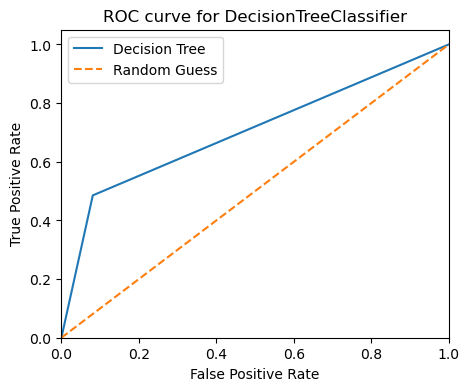

{'DecisionTreeClassifier'}
F1 Score: 0.5387755102040818
AUC-ROC Score: 0.702131983446645


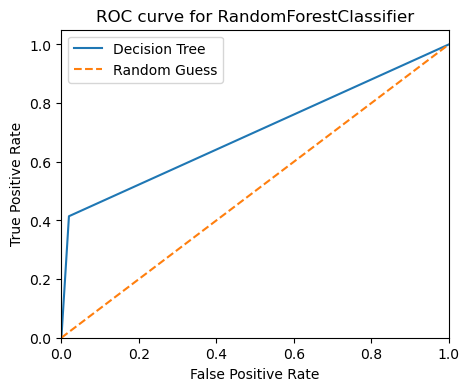

{'RandomForestClassifier'}
F1 Score: 0.555921052631579
AUC-ROC Score: 0.6973716622327324


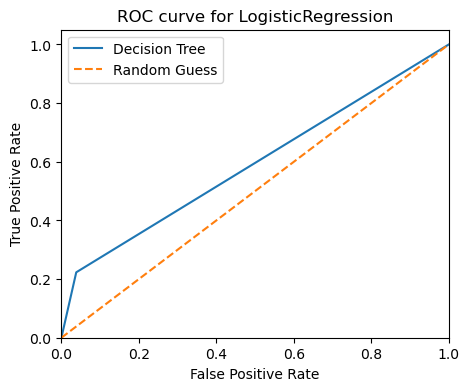

{'LogisticRegression'}
F1 Score: 0.325
AUC-ROC Score: 0.5923613163858508


(0.325, 0.5923613163858508)

In [27]:
get_f1_auc_roc_and_plot(DecisionTreeClassifier, random_state, features_train, target_train, features_valid, target_valid)
get_f1_auc_roc_and_plot(RandomForestClassifier, random_state, features_train, target_train, features_valid, target_valid)
get_f1_auc_roc_and_plot(LogisticRegression, random_state, features_train, target_train, features_valid, target_valid)

Decision Tree Classifier

- ROC Curve: The Decision Tree’s ROC curve shows a significant lift above the line of randomness (dashed line) but with some fluctuations, indicating variability in how well it separates the classes at different thresholds.
- F1 Score: 0.539 approximately, which is moderate. It suggests that the Decision Tree has a reasonable balance between precision and recall but isn’t highly effective, especially given the complexity that decision trees can capture.
- AUC-ROC Score: 0.702, which is fairly good and suggests that the model has a decent capability to discriminate between the positive and negative classes.

Random Forest Classifier

- ROC Curve: The Random Forest ROC curve is smoother and closer to the top-left corner compared to the Decision Tree, indicating better and more consistent performance across different thresholds.
- F1 Score: 0.556, which is slightly better than the Decision Tree, implying improvements in the balance between precision and recall.
- AUC-ROC Score: 0.697, which is slightly below the Decision Tree. This score still indicates good discriminatory ability, though it suggests that some of the additional complexity of the Random Forest might not be translating into better predictive performance.

Logistic Regression

- ROC Curve: The Logistic Regression curve is smoother but lies closer to the line of randomness across most of the curve, suggesting weaker performance in distinguishing between the classes.
- F1 Score: 0.325, significantly lower than the other two models, indicating poor performance in terms of precision and recall balance.
- AUC-ROC Score: 0.592, which is close to random guessing compared to the other models, showing limited capability in discrimination.

Conclusions

1.	Overall Performance: The Random Forest and Decision Tree models perform better than Logistic Regression in this case, with the Random Forest generally providing the best balance between F1 and AUC-ROC scores.
2.	Model Selection: Depending on the importance of either precision-recall balance (as reflected by the F1 score) or the overall ability to distinguish between classes (AUC-ROC), the Random Forest might be the preferred model given its slightly higher F1 score and comparable AUC-ROC score to the Decision Tree.

# Train Models with regard to Imbalance



## Using the 'balanced' arguement

### DecisionTreeClassifier

In [28]:
results = pd.DataFrame(columns=['f1_score', 'auc_roc', 'model', 'params', 'algorithm', 'method'])

In [29]:
# Ask if simple or deep tuning
if input('Would you like to perform deep tuning? (y, or any other key): ').lower() == 'y':

    decision_tree_params = {'max_depth': list(range(1, 21))+[None],
                            'splitter': ['best'],
                            'criterion': ['gini'],
                            'min_samples_split': [2],
                            'min_samples_leaf': [1, 2, 3],
                            'max_features': [None, 'sqrt']}

    random_forrest_params = {'n_estimators': list(range(100, 501, 100)),
                            'criterion': ['gini'],
                            'max_depth': [None],
                            'min_samples_split': [2],
                            'min_samples_leaf': [1, 2, 3],
                            'max_features': ['sqrt']}

    logistic_regression_params = {'duals': [False],
                                'penalties': ['l2'],
                                'solvers': ['liblinear'],
                                'max_iter': list(range(100, 501, 100))}
    
else: #Empty dictionaries for simple tuning
    decision_tree_params = {}
    random_forrest_params = {}
    logistic_regression_params = {}


In [30]:

results = update_results(results,
                            validate_DecisionTreeClassifier(features_train, target_train, features_valid, target_valid, random_state, class_weight=['balanced'], **decision_tree_params),
                            'balanced argument')

Testing DecisionTreeClassifier Parameters: 100%|██████████| 126/126 [00:13<00:00,  9.18iterations/s]


In [31]:
display(results)

,f1_score,auc_roc,model,params,algorithm,method
0,0.577491,0.769571,DecisionTreeClassifier(class_weight='balanced'...,"{'class_weight': 'balanced', 'max_depth': 6, '...",DecisionTreeClassifier,balanced argument


### RandomForrest

In [32]:
results = update_results(results, validate_RandomForrest(features_train, target_train, features_valid, target_valid,class_weight=['balanced'], **random_forrest_params), 'balanced argument')


Testing RandomForestClassifier Parameters: 100%|██████████| 15/15 [01:22<00:00,  5.51s/iterations]


In [33]:
display(results)

,f1_score,auc_roc,model,params,algorithm,method
0,0.577491,0.769571,DecisionTreeClassifier(class_weight='balanced'...,"{'class_weight': 'balanced', 'max_depth': 6, '...",DecisionTreeClassifier,balanced argument
1,0.598058,0.778833,"(DecisionTreeClassifier(max_features='sqrt', m...","{'class_weight': 'balanced', 'n_estimators': 1...",RandomForrestClassifier,balanced argument


### LogisticRegression

In [34]:
results = update_results(results, validate_LogisticRegression(features_train, target_train, features_valid, target_valid, random_state=random_state, class_weight=['balanced'], **logistic_regression_params), 'balanced argument')

Testing LogisticRegression Parameters: 5iterations [00:01,  4.28iterations/s]               


In [35]:
display(results)

,f1_score,auc_roc,model,params,algorithm,method
0,0.577491,0.769571,DecisionTreeClassifier(class_weight='balanced'...,"{'class_weight': 'balanced', 'max_depth': 6, '...",DecisionTreeClassifier,balanced argument
1,0.598058,0.778833,"(DecisionTreeClassifier(max_features='sqrt', m...","{'class_weight': 'balanced', 'n_estimators': 1...",RandomForrestClassifier,balanced argument
2,0.494767,0.698339,"LogisticRegression(class_weight='balanced', ra...","{'class_weight': 'balanced', 'solver': 'liblin...",LogisticRegression,balanced argument


## Upsampling

In [36]:
print(target_train.value_counts())

Exited
0    4778
1    1222
Name: count, dtype: int64


In [37]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3, random_state)

In [38]:
print(target_upsampled.value_counts())

Exited
0    4778
1    3666
Name: count, dtype: int64


### DecisionTreeClassifier

In [39]:
results = update_results(results, validate_DecisionTreeClassifier(features_upsampled, target_upsampled, features_valid, target_valid, random_state, **decision_tree_params), 'upsampling')

Testing DecisionTreeClassifier Parameters: 100%|██████████| 126/126 [00:18<00:00,  6.86iterations/s]


In [40]:
display(results[results['algorithm'] == 'DecisionTreeClassifier'])

,f1_score,auc_roc,model,params,algorithm,method
0,0.577491,0.769571,DecisionTreeClassifier(class_weight='balanced'...,"{'class_weight': 'balanced', 'max_depth': 6, '...",DecisionTreeClassifier,balanced argument
3,0.606452,0.770211,"DecisionTreeClassifier(max_depth=7, min_sample...","{'class_weight': None, 'max_depth': 7, 'splitt...",DecisionTreeClassifier,upsampling


Moderately better performance on DecisionTreeClassifier

### RandomForrestClassifier

In [41]:
results = update_results(results, validate_RandomForrest(features_upsampled, target_upsampled, features_valid, target_valid, **random_forrest_params), 'upsampling')

Testing RandomForestClassifier Parameters: 100%|██████████| 15/15 [02:15<00:00,  9.06s/iterations]


In [42]:
display(results[results['algorithm'] == 'RandomForrestClassifier'])

,f1_score,auc_roc,model,params,algorithm,method
1,0.598058,0.778833,"(DecisionTreeClassifier(max_features='sqrt', m...","{'class_weight': 'balanced', 'n_estimators': 1...",RandomForrestClassifier,balanced argument
4,0.623244,0.757876,"(DecisionTreeClassifier(max_features='sqrt', m...","{'class_weight': None, 'n_estimators': 300, 'c...",RandomForrestClassifier,upsampling


### LogisticRegression

In [43]:
results = update_results(results, validate_LogisticRegression(features_upsampled, target_upsampled, features_valid, target_valid, random_state=random_state, **logistic_regression_params), 'upsampling')

Testing LogisticRegression Parameters: 5iterations [00:01,  3.35iterations/s]               


In [44]:
display(results[results['algorithm'] == 'LogisticRegression'])

,f1_score,auc_roc,model,params,algorithm,method
2,0.494767,0.698339,"LogisticRegression(class_weight='balanced', ra...","{'class_weight': 'balanced', 'solver': 'liblin...",LogisticRegression,balanced argument
5,0.469055,0.671427,"LogisticRegression(random_state=12345, solver=...","{'class_weight': None, 'solver': 'liblinear', ...",LogisticRegression,upsampling


In [45]:
display(results)

,f1_score,auc_roc,model,params,algorithm,method
0,0.577491,0.769571,DecisionTreeClassifier(class_weight='balanced'...,"{'class_weight': 'balanced', 'max_depth': 6, '...",DecisionTreeClassifier,balanced argument
1,0.598058,0.778833,"(DecisionTreeClassifier(max_features='sqrt', m...","{'class_weight': 'balanced', 'n_estimators': 1...",RandomForrestClassifier,balanced argument
2,0.494767,0.698339,"LogisticRegression(class_weight='balanced', ra...","{'class_weight': 'balanced', 'solver': 'liblin...",LogisticRegression,balanced argument
3,0.606452,0.770211,"DecisionTreeClassifier(max_depth=7, min_sample...","{'class_weight': None, 'max_depth': 7, 'splitt...",DecisionTreeClassifier,upsampling
4,0.623244,0.757876,"(DecisionTreeClassifier(max_features='sqrt', m...","{'class_weight': None, 'n_estimators': 300, 'c...",RandomForrestClassifier,upsampling
5,0.469055,0.671427,"LogisticRegression(random_state=12345, solver=...","{'class_weight': None, 'solver': 'liblinear', ...",LogisticRegression,upsampling


## Using the Downsample Method

In [46]:
target_train.value_counts()

Exited
0    4778
1    1222
Name: count, dtype: int64

In [47]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3, random_state)

print(target_downsampled.value_counts())

Exited
0    1433
1    1222
Name: count, dtype: int64


### DecisionTreeClassifier

In [48]:
results = update_results(results, validate_DecisionTreeClassifier(features_downsampled, target_downsampled, features_valid, target_valid, random_state, **decision_tree_params), 'downsampling')

Testing DecisionTreeClassifier Parameters: 100%|██████████| 126/126 [00:06<00:00, 20.64iterations/s]


In [49]:
display(results[results['algorithm'] == 'DecisionTreeClassifier'])

,f1_score,auc_roc,model,params,algorithm,method
0,0.577491,0.769571,DecisionTreeClassifier(class_weight='balanced'...,"{'class_weight': 'balanced', 'max_depth': 6, '...",DecisionTreeClassifier,balanced argument
3,0.606452,0.770211,"DecisionTreeClassifier(max_depth=7, min_sample...","{'class_weight': None, 'max_depth': 7, 'splitt...",DecisionTreeClassifier,upsampling
6,0.615842,0.789733,"DecisionTreeClassifier(max_depth=6, random_sta...","{'class_weight': None, 'max_depth': 6, 'splitt...",DecisionTreeClassifier,downsampling


### RandomForrestClassifier

In [50]:
results = update_results(results, validate_RandomForrest(features_downsampled, target_downsampled, features_valid, target_valid, **random_forrest_params), 'downsampling')

Testing RandomForestClassifier Parameters: 100%|██████████| 15/15 [00:28<00:00,  1.89s/iterations]


In [51]:
display(results[results['algorithm'] == 'RandomForrestClassifier'])

,f1_score,auc_roc,model,params,algorithm,method
1,0.598058,0.778833,"(DecisionTreeClassifier(max_features='sqrt', m...","{'class_weight': 'balanced', 'n_estimators': 1...",RandomForrestClassifier,balanced argument
4,0.623244,0.757876,"(DecisionTreeClassifier(max_features='sqrt', m...","{'class_weight': None, 'n_estimators': 300, 'c...",RandomForrestClassifier,upsampling
7,0.631470,0.794315,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': None, 'n_estimators': 500, 'c...",RandomForrestClassifier,downsampling


### LogisticRegression

In [52]:
results = update_results(results, validate_LogisticRegression(features_downsampled, target_downsampled, features_valid, target_valid, random_state=random_state, **logistic_regression_params), 'downsampling')

Testing LogisticRegression Parameters: 5iterations [00:00,  9.52iterations/s]       


In [53]:
display(results[results['algorithm'] == 'LogisticRegression'])

,f1_score,auc_roc,model,params,algorithm,method
2,0.494767,0.698339,"LogisticRegression(class_weight='balanced', ra...","{'class_weight': 'balanced', 'solver': 'liblin...",LogisticRegression,balanced argument
5,0.469055,0.671427,"LogisticRegression(random_state=12345, solver=...","{'class_weight': None, 'solver': 'liblinear', ...",LogisticRegression,upsampling
8,0.502343,0.705630,"LogisticRegression(random_state=12345, solver=...","{'class_weight': None, 'solver': 'liblinear', ...",LogisticRegression,downsampling


# Review Results

In [54]:
# Sort results by descending f1_score, auc_roc
results = results.sort_values(by=['f1_score', 'auc_roc'], ascending=False, ignore_index=True)

display(results)

,f1_score,auc_roc,model,params,algorithm,method
0,0.631470,0.794315,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': None, 'n_estimators': 500, 'c...",RandomForrestClassifier,downsampling
1,0.623244,0.757876,"(DecisionTreeClassifier(max_features='sqrt', m...","{'class_weight': None, 'n_estimators': 300, 'c...",RandomForrestClassifier,upsampling
2,0.615842,0.789733,"DecisionTreeClassifier(max_depth=6, random_sta...","{'class_weight': None, 'max_depth': 6, 'splitt...",DecisionTreeClassifier,downsampling
3,0.606452,0.770211,"DecisionTreeClassifier(max_depth=7, min_sample...","{'class_weight': None, 'max_depth': 7, 'splitt...",DecisionTreeClassifier,upsampling
4,0.598058,0.778833,"(DecisionTreeClassifier(max_features='sqrt', m...","{'class_weight': 'balanced', 'n_estimators': 1...",RandomForrestClassifier,balanced argument
5,0.577491,0.769571,DecisionTreeClassifier(class_weight='balanced'...,"{'class_weight': 'balanced', 'max_depth': 6, '...",DecisionTreeClassifier,balanced argument
6,0.502343,0.705630,"LogisticRegression(random_state=12345, solver=...","{'class_weight': None, 'solver': 'liblinear', ...",LogisticRegression,downsampling
7,0.494767,0.698339,"LogisticRegression(class_weight='balanced', ra...","{'class_weight': 'balanced', 'solver': 'liblin...",LogisticRegression,balanced argument
8,0.469055,0.671427,"LogisticRegression(random_state=12345, solver=...","{'class_weight': None, 'solver': 'liblinear', ...",LogisticRegression,upsampling


In [55]:
save_results(results)

# Adjust Threshold

In [56]:
results = load_results()

display(results)

,f1_score,auc_roc,model,params,algorithm,method
0,0.631470,0.794315,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': None, 'n_estimators': 500, 'c...",RandomForrestClassifier,downsampling
1,0.623244,0.757876,"(DecisionTreeClassifier(max_features='sqrt', m...","{'class_weight': None, 'n_estimators': 300, 'c...",RandomForrestClassifier,upsampling
2,0.615842,0.789733,"DecisionTreeClassifier(max_depth=6, random_sta...","{'class_weight': None, 'max_depth': 6, 'splitt...",DecisionTreeClassifier,downsampling
3,0.606452,0.770211,"DecisionTreeClassifier(max_depth=7, min_sample...","{'class_weight': None, 'max_depth': 7, 'splitt...",DecisionTreeClassifier,upsampling
4,0.598058,0.778833,"(DecisionTreeClassifier(max_features='sqrt', m...","{'class_weight': 'balanced', 'n_estimators': 1...",RandomForrestClassifier,balanced argument
5,0.577491,0.769571,DecisionTreeClassifier(class_weight='balanced'...,"{'class_weight': 'balanced', 'max_depth': 6, '...",DecisionTreeClassifier,balanced argument
6,0.502343,0.705630,"LogisticRegression(random_state=12345, solver=...","{'class_weight': None, 'solver': 'liblinear', ...",LogisticRegression,downsampling
7,0.494767,0.698339,"LogisticRegression(class_weight='balanced', ra...","{'class_weight': 'balanced', 'solver': 'liblin...",LogisticRegression,balanced argument
8,0.469055,0.671427,"LogisticRegression(random_state=12345, solver=...","{'class_weight': None, 'solver': 'liblinear', ...",LogisticRegression,upsampling


The Random Forrest Classifier takes the top two spots of all the methods and algorithms tested. The F1 score the downsampling method and upsampling method are within .01 of each other, but the AUC ROC score is significantly better for the downsampling method.

We will keep the top two results and plot the AUC ROC curve to visually compare the two models. 

In [57]:
# Keep only the top 2 results
results = results.head(2)

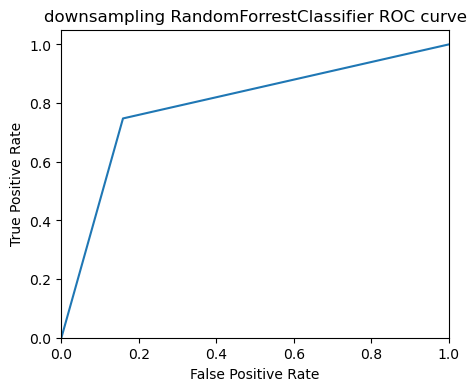

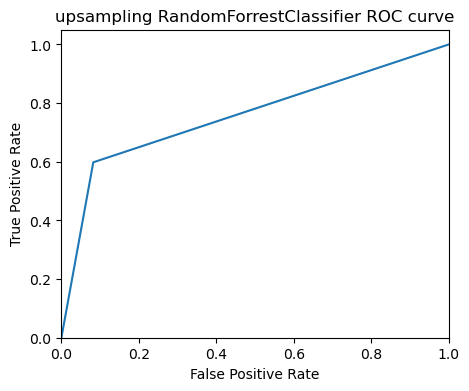

In [58]:
# Plot the AuC-ROC curve for the top 2 models
for i, row in results.iterrows():
    model = row['model']
    predictions_valid = model.predict(features_valid)
    fpr, tpr, thresholds = roc_curve(target_valid, predictions_valid)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{row['method']} {row['algorithm']} ROC curve")
    plt.show()

Because there is clearly better performance for the downsampling method with the Random Forrest Classifier, we will drop the rest of the models from the results df.

In an attempt to further improve the F1 and AUC ROC scores, we will iterate over a range of thresholds (from 0 to 1, at .02 intervals).

In [59]:
results = results.head(1)

results = find_threshold(results, features_valid, target_valid)

display(results)

,f1_score,auc_roc,model,params,algorithm,method,threshold
0,0.633929,0.783969,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': None, 'n_estimators': 500, 'c...",RandomForrestClassifier,downsampling,0.54
1,0.631470,0.794315,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': None, 'n_estimators': 500, 'c...",RandomForrestClassifier,downsampling,0.50
2,0.629405,0.768407,"(DecisionTreeClassifier(max_features='sqrt', r...","{'class_weight': None, 'n_estimators': 500, 'c...",RandomForrestClassifier,downsampling,0.58


A threshold value of .54 returns the best f1 score, while a threshold of .50 returns the best AUC ROC score. In this case we will prioritize the F1 score and select the model with the best F1 as our best model for final testing.

In [60]:
best_result = results.iloc[0]

# Final Test

In [61]:
# Concat the training and validation data
features_train = pd.concat([features_train, features_valid])
target_train = pd.concat([target_train, target_valid])

# Downsample the training data
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3, random_state)

# Train the model on the downsampled data
model = best_result['model']
model.fit(features_downsampled, target_downsampled)

# Predict the probabilities of the positive class
probabilities_one_test = model.predict_proba(features_test)[:, 1]

# Set the threshold
threshold = best_result['threshold']
predictions_test = probabilities_one_test > threshold

# Calculate the f1 score
f1 = f1_score(target_test, predictions_test)
# Calculate the auc_roc score
auc_roc = roc_auc_score(target_test, predictions_test)

print(f"F1 Score: {f1}")
print(f"AUC-ROC Score: {auc_roc}")


F1 Score: 0.6166281755196305
AUC-ROC Score: 0.7677461745258356


# Conclusion

In the task for creating a model capable of predicting Beta Bank customer churn with an f1 score of at least .59, 